Available columns: ['Age', 'Time_Spent_on_Videos', 'Quiz_Attempts', 'Quiz_Scores', 'Forum_Participation', 'Assignment_Completion_Rate', 'Final_Exam_Score', 'Feedback_Score', 'Gender_Female', 'Gender_Male', 'Gender_Other', 'Course_Name_Cybersecurity', 'Course_Name_Data Science', 'Course_Name_Machine Learning', 'Course_Name_Python Basics', 'Course_Name_Web Development', 'Learning_Style_Auditory', 'Learning_Style_Kinesthetic', 'Learning_Style_Reading/Writing', 'Learning_Style_Visual']

Final features used: ['Age', 'Time_Spent_on_Videos', 'Quiz_Attempts', 'Quiz_Scores', 'Forum_Participation', 'Assignment_Completion_Rate', 'Final_Exam_Score', 'Feedback_Score', 'Gender_Female', 'Gender_Male', 'Gender_Other', 'Course_Name_Cybersecurity', 'Course_Name_Data Science', 'Course_Name_Machine Learning', 'Course_Name_Python Basics', 'Course_Name_Web Development', 'Learning_Style_Auditory', 'Learning_Style_Kinesthetic', 'Learning_Style_Reading/Writing', 'Learning_Style_Visual', 'Efficiency', 'Consiste

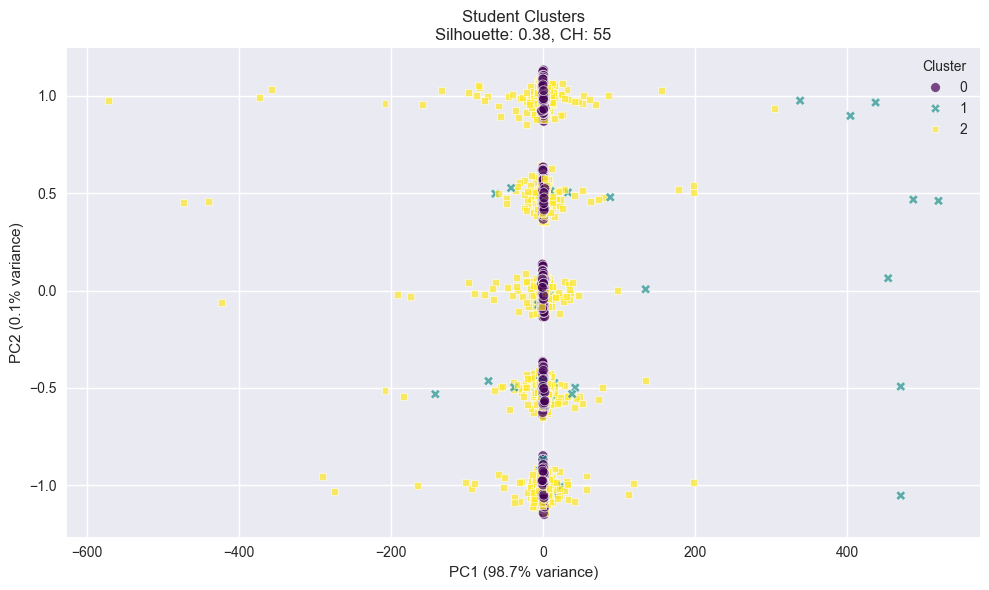


=== Results Saved ===
Clustered data: data/processed/final_student_clusters.csv
Model pipeline: models/final_gmm_pipeline.pkl
Visualization: reports/figures/final_clusters.png


In [3]:
# %% [markdown]
# # Robust GMM Clustering for Student Data
# Objective: Identify balanced student groups using available features

# %% [markdown]
# ## 1. Environment Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import joblib

plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

# %% [markdown]
# ## 2. Data Loading
df = pd.read_csv("../data/processed/preprocessed_students.csv")
print("Available columns:", df.columns.tolist())

# %% [markdown]
# ## 3. Feature Engineering

# Start with numeric columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Add 'Efficiency' safely
if all(col in df.columns for col in ['Quiz_Scores', 'Time_Spent_on_Videos']):
    df['Efficiency'] = df['Quiz_Scores'] / (df['Time_Spent_on_Videos'] + 1)
    numerical_cols += ['Efficiency']

# Add 'Consistency' safely
if 'Quiz_Scores' in df.columns:
    df['Consistency'] = df['Quiz_Scores'].rolling(window=3, min_periods=1).std().fillna(0)
    numerical_cols += ['Consistency']

X = df[numerical_cols]
print("\nFinal features used:", X.columns.tolist())

# %% [markdown]
# ## 4. Data Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# %% [markdown]
# ## 5. Bayesian GMM Clustering
bgmm = BayesianGaussianMixture(
    n_components=3,
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.01,
    covariance_type='full',
    random_state=42,
    n_init=3,
    max_iter=500
)

clusters = bgmm.fit_predict(X_scaled)

# Evaluation
score = silhouette_score(X_scaled, clusters)
ch_score = calinski_harabasz_score(X_scaled, clusters)

print(f"\nSilhouette Score: {score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.0f}")
print("\nCluster Distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# %% [markdown]
# ## 6. Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=clusters,
    palette='viridis',
    alpha=0.7,
    s=50,
    style=clusters,
    legend='full'
)

plt.title(f'Student Clusters\nSilhouette: {score:.2f}, CH: {ch_score:.0f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("../reports/figures/final_clusters.png", dpi=300)
plt.show()

# %% [markdown]
# ## 7. Export Results
df['Cluster'] = clusters

df.to_csv("../data/processed/final_student_clusters.csv", index=False)

joblib.dump({
    'scaler': scaler,
    'model': bgmm,
    'features': X.columns.tolist()
}, "../models/final_gmm_pipeline.pkl")

print("\n=== Results Saved ===")
print("Clustered data: data/processed/final_student_clusters.csv")
print("Model pipeline: models/final_gmm_pipeline.pkl")
print("Visualization: reports/figures/final_clusters.png")


In [4]:
cluster_summary = df.groupby('Cluster')[[
    'Age', 'Time_Spent_on_Videos', 'Quiz_Attempts', 'Quiz_Scores',
    'Forum_Participation', 'Assignment_Completion_Rate', 'Final_Exam_Score',
    'Feedback_Score', 'Efficiency', 'Consistency'
]].mean().round(2)

display(cluster_summary)

,Age,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Final_Exam_Score,Feedback_Score,Efficiency,Consistency
Cluster,,,,,,,,,,
0,-0.00,0.33,0.01,0.01,0.01,0.00,-0.00,0.00,0.06,0.89
1,-0.02,-0.06,-0.01,-0.04,-0.04,0.02,-0.06,0.01,13.45,0.91
2,0.02,-1.16,-0.02,-0.02,-0.03,-0.01,0.02,-0.02,-3.36,0.99



Cluster distribution summary:
Total students: 10000
0    7475
1     423
2    2102
Name: count, dtype: int64


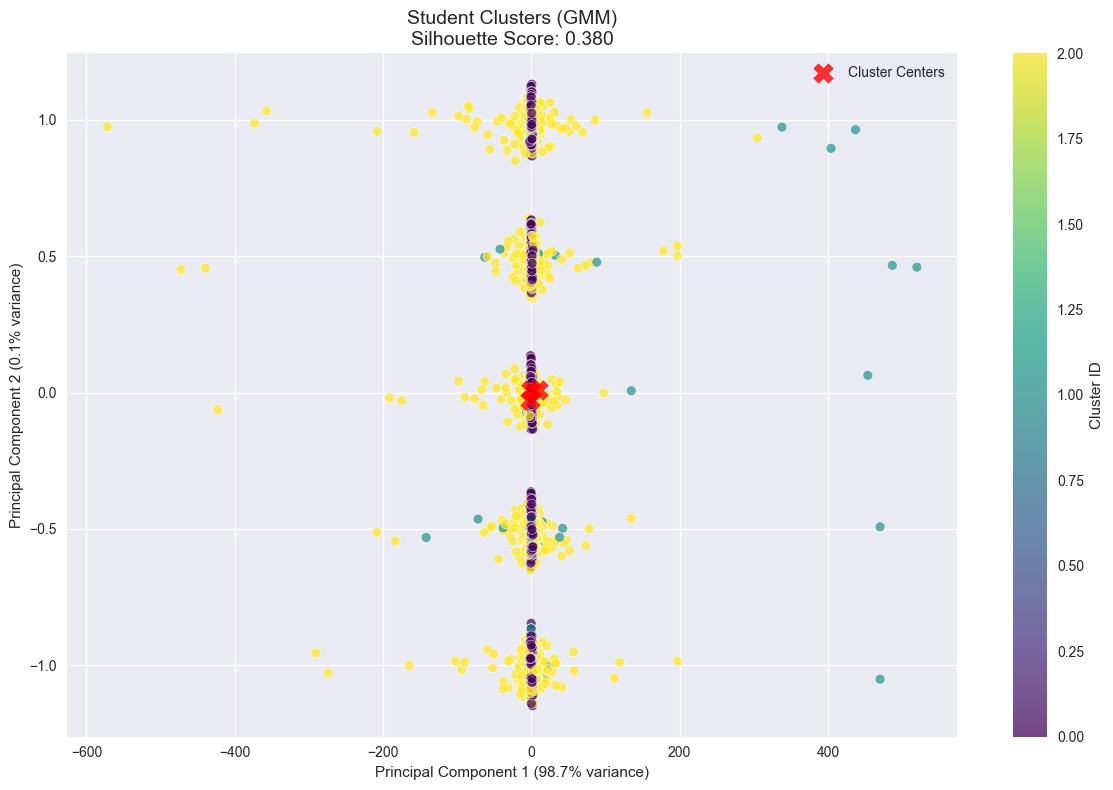


Cluster characteristics (mean values):


,Age,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Final_Exam_Score,Feedback_Score,Gender_Female,Gender_Male,Gender_Other,Course_Name_Cybersecurity,Course_Name_Data Science,Course_Name_Machine Learning,Course_Name_Python Basics,Course_Name_Web Development,Learning_Style_Auditory,Learning_Style_Kinesthetic,Learning_Style_Reading/Writing,Learning_Style_Visual,Efficiency,Consistency
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,-0.004312,0.328306,0.006288,0.006376,0.010455,0.001084,-0.002630,0.003747,0.508763,0.491237,0.000000,0.201070,0.201472,0.200803,0.200669,0.195987,0.248562,0.238127,0.257258,0.256054,0.057335,0.893027
1,-0.015565,-0.055573,-0.014134,-0.036093,-0.035083,0.016029,-0.056213,0.014421,0.009456,0.009456,0.981087,0.196217,0.174941,0.215130,0.208038,0.205674,0.215130,0.238771,0.281324,0.264775,13.449692,0.906278
2,0.018465,-1.156318,-0.019516,-0.015411,-0.030120,-0.007081,0.020665,-0.016228,0.513321,0.486679,0.000000,0.209324,0.192198,0.214558,0.193149,0.190771,0.251665,0.267364,0.243578,0.237393,-3.357262,0.994051



=== Results Saved ===
Clustered data saved to: ../data/processed/students_clustered_final.csv
Model pipeline saved to: ../models/gmm_clustering_pipeline.pkl
Visualization saved to: ../reports/figures/gmm_clusters_final.png

Feature importance per cluster:

Cluster 0 (7475 students):
Consistency                       0.893027
Gender_Female                     0.508763
Gender_Male                       0.491237
Time_Spent_on_Videos              0.328306
Learning_Style_Reading/Writing    0.257258
dtype: float64

Cluster 1 (423 students):
Efficiency                        13.449692
Gender_Other                       0.981087
Consistency                        0.906278
Learning_Style_Reading/Writing     0.281324
Learning_Style_Visual              0.264775
dtype: float64

Cluster 2 (2102 students):
Consistency                   0.994051
Gender_Female                 0.513321
Gender_Male                   0.486679
Learning_Style_Kinesthetic    0.267364
Learning_Style_Auditory       0.251665


In [ ]:
# %% [markdown]
# ## 7. Cluster Visualization

# First ensure we have the cluster labels
print("\nCluster distribution summary:")
print(f"Total students: {len(df)}")
print(pd.Series(clusters).value_counts().sort_index())

# Dimensionality reduction for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create the visualization figure
plt.figure(figsize=(12, 8))

# Main scatter plot
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.7,
    s=50,
    edgecolor='w',
    linewidth=0.5
)

# Add cluster centers
centers_pca = pca.transform(bgmm.means_)
plt.scatter(
    centers_pca[:, 0], centers_pca[:, 1],
    c='red', marker='X', s=200,
    alpha=0.8, label='Cluster Centers'
)

# Add annotations
plt.title(f'Student Clusters (GMM)\nSilhouette Score: {score:.3f}', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter, label='Cluster ID')
plt.legend()

# Save and show
plt.tight_layout()
plt.savefig("../reports/figures/gmm_clusters_final.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 8. Cluster Interpretation & Export

# Add clusters to original data
df['Cluster'] = clusters

# Calculate cluster characteristics
cluster_stats = df.groupby('Cluster')[numerical_cols].mean()
print("\nCluster characteristics (mean values):")
display(cluster_stats.style.background_gradient(cmap='Blues'))

# Save results
output_path = "../data/processed/students_clustered_final.csv"
df.to_csv(output_path, index=False)

# Save model pipeline
model_path = "../models/gmm_clustering_pipeline.pkl"
joblib.dump({
    'scaler': scaler,
    'pca': pca,
    'gmm': bgmm,
    'features': list(X.columns)
}, model_path)

print("\n=== Results Saved ===")
print(f"Clustered data saved to: {output_path}")
print(f"Model pipeline saved to: {model_path}")
print(f"Visualization saved to: ../reports/figures/gmm_clusters_final.png")

# %% [markdown]
# ## 9. Next Steps Analysis

# Show feature importance for each cluster
print("\nFeature importance per cluster:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster][numerical_cols]
    print(f"\nCluster {cluster} ({len(cluster_data)} students):")
    print(cluster_data.mean().sort_values(ascending=False).head(5))